In [1]:
# All auxiliary code is in ../src

import sys

sys.path.append("../src/")

# Anomaly/Outlier detection

In a set of instances, an outlier is...

- Something unusual. A penguin in this classroom.
- Something extreme. A cassata at a cake competition.

In [2]:
from datasets import load_dataset
from transformations import center_and_scale
import pandas


train_dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
test_dataset = load_dataset("mstz/adult", "income")["test"].to_pandas()

train_labels = train_dataset["over_threshold"]
test_labels = test_dataset["over_threshold"]

train_dataset = train_dataset.drop("over_threshold", axis="columns")
test_dataset = test_dataset.drop("over_threshold", axis="columns")

# note: here for simplicity we focus only on numeric features, but consider encoding categorical features too
numeric_train_dataset = train_dataset.select_dtypes(include="number")
numeric_test_dataset = test_dataset.select_dtypes(include="number")
data_only_dataset = pandas.concat((numeric_train_dataset, numeric_test_dataset), axis="rows")
data_only_dataset, _ = center_and_scale(data_only_dataset)

joined_full_dataset = pandas.concat((train_dataset, test_dataset), axis="rows")
dataset_with_outlier_scores = joined_full_dataset.copy()

/Users/lorenzomannocci/anaconda3/envs/dm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

# Distributional approach

Estimate data distribution, grade instances by density.

One of $k$ models $M_{\theta_1}, \dots, M_{\theta_k}$ is sampled, each with a sampling probability $m_i$.


![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/linalg/1x/mixture.png "Mixture")

Estimate model parameters with the EM algorithm.

The method fits the model n_init times and sets the parameters with which the model has the largest likelihood or lower bound. Within each trial, the method iterates between E-step and M-step for max_iter times until the change of likelihood or lower bound is less than tol

In [3]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn


k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

dataset_with_outlier_scores.loc[:, "density_degree"] = outlier_degrees

<Axes: >

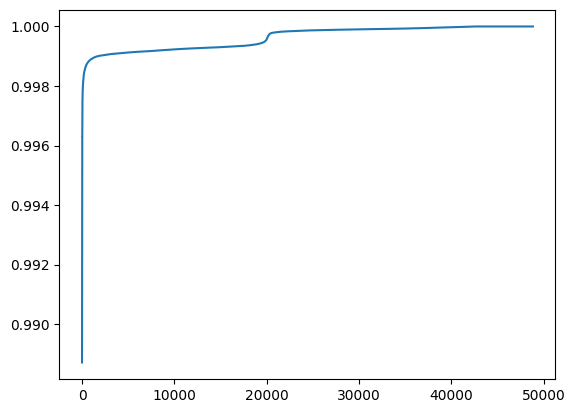

In [4]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(dataset_with_outlier_scores.shape[0]),
    y=sorted_outlier_degrees
)

---

# Connectivity approach

Assumption: Inliers have lower reach than their neighbors. We formalize this in a reach ratio
$$\tilde{o}^k_{i, j} = \dfrac{\bar{\gamma}^k(x_i)}{\bar{\gamma}^k(x_j)},$$
which is $1$ for pairs $x_i, x_j$ with equal k-neighbors concentration, and $> 1$ for instances with different concentrations, $x_i$ laying in a sparser area of the space.


![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/outliers/0.75x/reach3%400.75x.png "Reach")

*Reach@3 (*$\gamma^3(\cdot)$*)* of two instances.


It is a density-based unsupervised outlier detection method which uses Local Outlier Factor (LOF). LOF is the anomaly score, computed for each sample.
It considers a local density, in which the denisity of a point is relative to that of its k nearest neighbors. 
LOF is computed as the average of the ratios of the density of the sample under analysis and the density of its nearest neighbors. The outliers are the ones with largest LOF values.

sklearn implementation:
negative_outlier_factor_ndarray of shape (n_samples,)
The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.
The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors.


Since it is based on KNN, you have to set the hyper parameters of KNN.

In [5]:
from sklearn.neighbors import LocalOutlierFactor

k = 25

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
dataset_with_outlier_scores.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

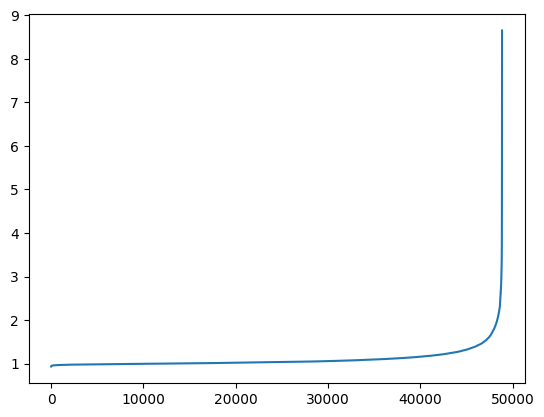

In [6]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

# to achieve comparable degrees among different algorithms,
# we normalize distance-based scores by the maximum possible distance
# distances = squareform(pdist(data_only_dataset.values))
# maximum_possible_radius = distances.max()
# normalization_factor = maximum_possible_radius / k
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(dataset_with_outlier_scores.shape[0]),
    y=sorted_outlier_degrees
)

---

# One-class SVM

Our goal: to best separate the outliers, that is, to **maximize** the distance between them and the inliers. In other words, to find a discriminative criterion maximizing the distance between inliers and outliers.

![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/linalg/0.5x/planes%400.5x.png "SVM")


*Separating hyperplane.*

Signed distance is positive for an inlier and negative for an outlier.

In [7]:
from sklearn.svm import OneClassSVM


kernel = "rbf"
# kernel = "linear"
# kernel = "poly"
algorithm = OneClassSVM(kernel=kernel)
algorithm.fit(data_only_dataset)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(data_only_dataset)
outlier_distance_scores = algorithm.score_samples(data_only_dataset)

dataset_with_outlier_scores.loc[:, "oneclass_svm_degree"] = outlier_distance_scores
dataset_with_outlier_scores.loc[:, "oneclass_svm_degree_binary"] = (outlier_classification_scores  + 1) % 2  # map to {0, 1}

if kernel == "linear":
    support_vectors = data_only_dataset.iloc[algorithm.support_]
    
else:
    support_vectors = None

<Axes: >

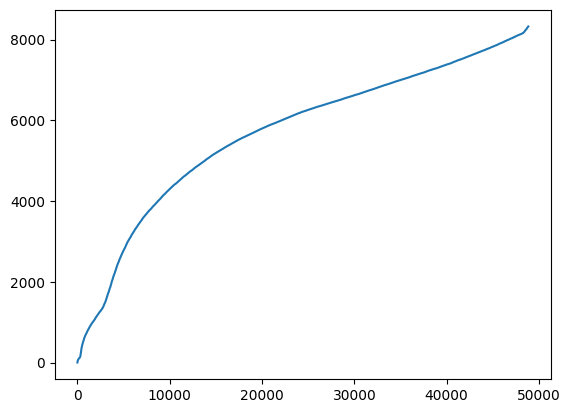

In [8]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_distance_scores)

# to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
# normalization_factor = sorted_outlier_degrees[-1]
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "oneclass_svm_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(dataset_with_outlier_scores.shape[0]),
    y=sorted_outlier_degrees
)

---

# Isolation forest

An isolation forest $T$ is comprised of several isolation trees, further sampling the hyperplane space.
Outlier degree
$$\tilde{o}(x_i) = 2^{-\dfrac{\Sigma_{t \in T} path(x_i, t)}{\mid T \mid c} }$$

![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/outliers/0.5x/isointersect%400.5x.png "SVM")

Average anomaly score of X of the base classifiers.

The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

The measure of normality of an observation given a tree is the depth of the leaf containing this observation, which is equivalent to the number of splittings required to isolate this point. In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree is added.

In [9]:
from sklearn.ensemble import IsolationForest


max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

dataset_with_outlier_scores.loc[:, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

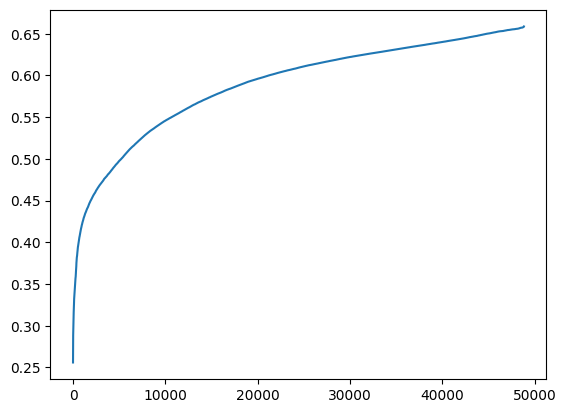

In [10]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)


seaborn.lineplot(
    x=range(dataset_with_outlier_scores.shape[0]),
    y=sorted_outlier_degrees
)

In [11]:
dataset_with_outlier_scores

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,density_degree,lof_degree,oneclass_svm_degree,oneclass_svm_degree_binary,isolation_forest_degree,isolation_forest_scores
0,43,0.0,0.0,10,34278,35,Married-civ-spouse,United-States,Sales,White,Husband,True,Private,0.999853,1.622111,6456.123754,0,0.603263,0.0
1,23,0.0,0.0,3,244698,35,Never-married,Mexico,Farming-fishing,White,Other-relative,True,Private,0.999920,1.082033,3493.946744,0,0.552261,0.0
2,39,0.0,0.0,10,118286,40,Married-civ-spouse,United-States,Sales,Black,Husband,True,Private,0.999284,1.001079,7956.180791,0,0.653908,0.0
3,35,0.0,0.0,9,126675,46,Divorced,?,Craft-repair,White,Not-in-family,True,Private,0.999859,0.981331,7596.139087,0,0.643286,0.0
4,66,0.0,0.0,13,28367,99,Married-civ-spouse,United-States,Priv-house-serv,White,Other-relative,True,Private,1.000000,1.405055,458.341761,0,0.428878,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,35,0.0,0.0,11,216256,60,Never-married,United-States,Other-service,White,Not-in-family,True,Private,0.999928,1.126996,6327.367156,0,0.607849,0.0
12207,38,0.0,0.0,9,159179,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,0.999322,1.043190,8090.934177,0,0.656957,0.0
12208,42,0.0,0.0,13,37997,40,Married-civ-spouse,United-States,Exec-managerial,White,Husband,True,Federal-gov,0.999163,0.989845,5997.176332,0,0.614381,0.0
12209,29,0.0,0.0,9,183061,48,Married-civ-spouse,United-States,Craft-repair,Amer-Indian-Eskimo,Husband,True,Private,0.999876,1.103944,7358.492889,0,0.642221,0.0


---

# PyOd

[Reference.](https://github.com/yzhao062/pyod)

A library with many more outlier detection algorithms.

In [ ]:
from pyod.models import ECOD  # distribution-based
from pyod.models import GMM  # distribution-based
from pyod.models import ABOD  # angle-based
from pyod.models import COPOD  # manifold-based
from pyod.models import LOF, COF, LOCI  # connection-based
from pyod.models import XGBOD # isolation-based


algorithm = ...
algorithm.fit(data_only_dataset)

# outlier scores only
outlier_scores = algorithm.decision_function(data_only_dataset)
outlier_labels = algorithm.predict(data_only_dataset)